In [64]:
import re
import random
import pandas as pd
import hashlib

In [65]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [66]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Windows PATH Variable,54.729453,1.824315,5.294364,30
Node.JS and React,743.383512,23.980113,34.544279,31
"Mexican Gothic, Moreno-Garcia",1063.034944,37.965534,63.588300,28
Azure Functions Core Tools,735.081730,43.240102,57.965072,17
C# Basics,60.405461,60.405461,60.405461,1
Django,2458.520160,61.463004,81.351864,40
Node.js and Vite,2536.441876,61.864436,86.673773,41
Python,5515.280703,70.708727,183.381459,78
Azure Files Documentation,4490.052438,74.834207,162.119097,60
Active Directory and Azure Files,2984.988100,80.675354,121.490868,37


# Histogram

sum of ages: ~54611.51


<Axes: >

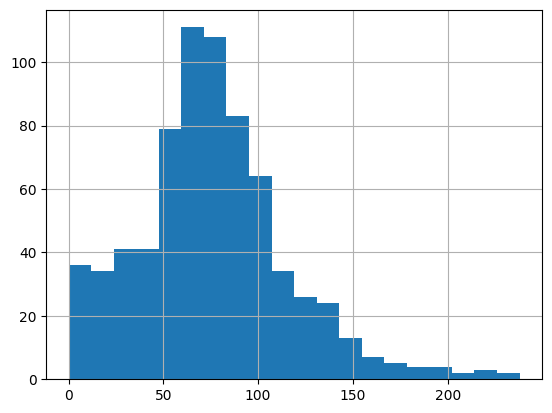

In [67]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~54611.51


<Axes: >

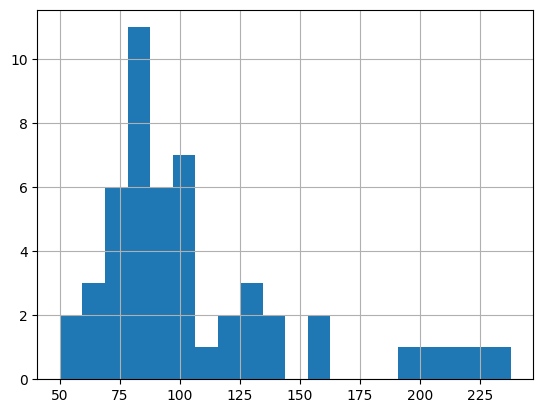

In [68]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='JavaScript Concepts']['age'].hist(bins=20)

# Completely Random Shuffle

In [69]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [70]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [71]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [72]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [73]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [74]:
n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 721
Total card age: 54611.51


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,C# Basics,How do basic data types work in C#?\n\nC#: Sta...,9bcbb2098a72dbaa4a613d64f34446be,60.405461,60.405461,-60.405461,60.405461,0.554518,1,0,0,-60.405461
1,Azure VM + Developer,.ssh/known_hosts\nA file used by SSH to store ...,d4f9279a08485d568b293f2c2f417297,134.518712,102.721788,-134.518712,308.165365,0.513952,3,0,0,-134.518712
2,Azure VM + Developer,Makefile / Task Runner\nA scriptable command l...,1d82509533a1c1268c27521f159ed808,101.997730,102.721788,-134.518712,308.165365,0.513952,3,1,0,-101.997730
3,Azure VM + Developer,Inbound NAT Rule\nA networking rule used with ...,3d25b6d3bb4c6bcfe75bca0cb6a22ddc,71.648923,102.721788,-134.518712,308.165365,0.513952,3,2,0,-71.648923
4,Azure Compute Gallery,Cross-Subscription Sharing – ACG images can be...,de0e14f5d2c232476acc689c26c4078f,163.227597,98.902394,-163.227597,791.219150,0.601787,8,0,0,-163.227597
5,Azure Compute Gallery,Azure DevOps Pipelines for Image Deployment – ...,7f9dc58f909efc213b64a0697735712c,152.912933,98.902394,-163.227597,791.219150,0.601787,8,1,0,-152.912933
6,Azure Compute Gallery,Replication Time Constraints – Image replicati...,f5615ce9f50e2f668a32d12784e21991,113.054999,98.902394,-163.227597,791.219150,0.601787,8,2,0,-113.054999
7,Azure Compute Gallery,Image Retention Policy – A strategy for keepin...,70c2d698cafb110aac81fc77dbba5e31,97.630350,98.902394,-163.227597,791.219150,0.601787,8,3,0,-97.630350
8,Azure Compute Gallery,Azure Marketplace Image as a Base – Using a pr...,0d150bb03591ea0166f17b89e7412ee1,84.690527,98.902394,-163.227597,791.219150,0.601787,8,4,0,-84.690527
9,pfSense,"To check for updates to pfSense software, navi...",438fd54e363098f3194d6e2a852d90ee,178.637999,93.751213,-178.637999,1125.014557,0.238576,12,0,0,-178.637999



## Random

In [75]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [76]:
existing_cards.head(10)['age'].sum()

np.float64(1158.7252295292642)

In [77]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
94,JavaScript Concepts,Generate distinct arrays with fill() + map()\n...,1c477652c74da3a626b132108ec4229f,237.946848,106.554384,-237.946848,5327.719198,0.088337,50,0,0,-237.946848
34,PnP PowerShell,REST API Endpoints\nSpecific URLs used to acce...,b12f5012328f32a6c689485970705806,227.581726,101.181483,-227.581726,2023.629657,0.995132,20,0,0,-227.581726
95,JavaScript Concepts,Express.js: A minimalist web framework for Nod...,425c10164d26897fdad3f9d7c2c6f523,224.634060,106.554384,-237.946848,5327.719198,0.088337,50,1,0,-224.634060
99,Microsoft Purview,"When you create your DLP policies, you should ...",8ec1edc0f421bb7de2884cb3c7089b3e,220.287521,85.121609,-220.287521,4256.080428,0.182570,50,0,0,-220.287521
44,Vocab,"Something Rotten, Fforde\nSalver\nnoun | SAL-v...",c8d10134bc737eb530dfa3f6d3e44e00,214.303378,102.661631,-214.303378,2258.555886,0.001226,22,0,0,-214.303378
96,JavaScript Concepts,Many operators coerce the operands into number...,c7910dc971abc5da390f0193c2ffbdc8,213.175482,106.554384,-237.946848,5327.719198,0.088337,50,2,0,-213.175482
100,Microsoft Purview,Run the policy in simulation mode with notific...,3a95ac540d1e377383ba60aeb1da4f08,207.030442,85.121609,-220.287521,4256.080428,0.182570,50,1,0,-207.030442
97,JavaScript Concepts,Arrow Functions: Arrow functions provide a con...,2e3769781211a560564f81d13f2051b9,200.772718,106.554384,-237.946848,5327.719198,0.088337,50,3,0,-200.772718
98,JavaScript Concepts,Logical AND (&&) and OR (||) Statements\nif (c...,8541c9ae716e3f5474869ab92784fcc8,198.065610,106.554384,-237.946848,5327.719198,0.088337,50,4,0,-198.065610
45,Vocab,"How to Sell a Haunted House, Hendrix\nStollen ...",2f0f1d406aece7f1fd77835411449718,195.987256,102.661631,-214.303378,2258.555886,0.001226,22,1,0,-195.987256


In [78]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 75.744'